### Similarity Score

When doing similarity search using vector databases, we search for k closest vectors. But how does that work internally?

Answer is that each question is converted to a corresponding embedding and then a distance strategy is used to find distance between the vectors. For FAISS, the distance strategy is set to DistanceStrategy.EUCLIDEAN_DISTANCE by default.

Now, if we want similarity score to be between -1 to 1, we must use cosine similarity for search similarity score. Here I will demonstrate how to use cosine similarity and compare vectors for their similarity score.

Here 1 means vectors are same and -1 means vectors are opposite

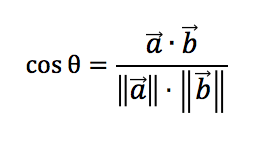

The above is formula for cosine similarity where `a` and `b` are 2 vectors(embeddings of a string)

We will take user query and make vector embeddings as vector `a` and then for all docs in vectorDB, run this formula for vectors of each chunk/document. Then we sort it based on highest similarity

In [2]:
%pip install -q langchain langchain-community langchain-text-splitters scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Chunk the pdf into chunks and convert them to documents

- load the pdf using langchain PyPDFLoader
- chunk into sizes of 250 with 20 overlap for context via RecursiveCharacterTextSplitter

In [8]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

file_path = "../data/who_stats_2022.pdf"

loader = PyPDFLoader(file_path=file_path)
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=250,
    chunk_overlap=20,
)

pdf_pages = loader.load_and_split(text_splitter=text_splitter)


In [9]:
len(pdf_pages)

2405

In [10]:
vars(pdf_pages[100])

{'id': None,
 'metadata': {'source': '../data/who_stats_2022.pdf', 'page': 8},
 'page_content': '33% in 2000. The number of adults aged 30–79 years with raised blood pressure (hypertension) is estimated \nto have almost doubled to 1.28 billion between 1990 and 2019, mainly due to population growth and ageing.',
 'type': 'Document'}

#### We want similarity score of chunks with this query

For this we have to create embeddings for each page_content as well

In [80]:
query = "What was effect of covid 19 in middle east?"

In [81]:
chunk_texts = [p.page_content for p in pdf_pages] # get only texts as we focus on similarity score

#### Create embeddings using Hugging face functions

In [82]:
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

# use the open-source embedding function to convert text to embeddings, can choose another function as per leaderboard - https://huggingface.co/spaces/mteb/leaderboard
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

d:\VS Code\python\GenAI-Cookbook\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [83]:
chunk_embeddings = embedding_function.embed_documents(chunk_texts) # gives list of embeddings(which are list of float numbers)

In [84]:
# print(chunk_embeddings[0])
len(chunk_embeddings[0]) # linear vector of length 384 is generated as embedding for 0th chunk text

384

#### Embed the user query

In [85]:
query_embedding = embedding_function.embed_query(query)

In [87]:
query_embedding.shape # not a numpy array

AttributeError: 'list' object has no attribute 'shape'

In [88]:
%pip install -q numpy

Note: you may need to restart the kernel to use updated packages.


In [89]:
import numpy as np

query_embedding = np.array(query_embedding).reshape(1,-1) # for cosine similarity

In [90]:
query_embedding.shape

(1, 384)

In [91]:
chunk_embeddings = [np.array(ce).reshape(1,-1) for ce in chunk_embeddings] # reshape for cosine similarity

#### Create cosine similarity and give top 10 similar vectors

In [92]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(query_embedding, chunk_embeddings[0])

array([[0.21760679]])

The above is similarity score in range [0,1] for query and chunk embedding based off cosine similarity

#### Doing cosine similarity for all chunks

In [93]:
similarities = [cosine_similarity(query_embedding, ce) for ce in chunk_embeddings]

In [94]:
similarities[1]

array([[0.21760679]])

In [95]:
similarities[1][0][0]

0.2176067916557493

In [96]:
similarities[1].shape

(1, 1)

### Sort based off similarities

In [97]:
chunk_score_list = [(chunk_texts[i], similarities[i][0][0]) for i in range(len(similarities))]

In [98]:
chunk_score_list[:3]

[('World \nHealth \nStatistics \n2022\nMonitoring  \nhealth for the  \nSDG s\nSustainable Development Goals',
  0.2176067916557493),
 ('World \nHealth \nStatistics \n2022\nMonitoring  \nhealth for the  \nSDG s\nSustainable Development Goals',
  0.2176067916557493),
 ('World health statistics 2022: monitoring health for the SDGs, sustainable development goals\nISBN 978-92-4-005114-0 (electronic version)\nISBN 978-92-4-005115-7 (print version)\n© World Health Organization 2022',
  0.23928306724151702)]

In [101]:
sorted_chunk_score_list = sorted(chunk_score_list, key=lambda x: x[1], reverse=True) # sort based on similarity(2nd ele of tuple) in descending order

#### Getting the top 10 most similar chunks

In [102]:
sorted_chunk_score_list[:10]

[('true impact of the COVID-19 pandemic. Iraq and Tunisia also reported \non monthly total deaths and were able to determine excess deaths \nin 2020 in comparison to 2019. \nSeven countries in the Eastern Mediterranean Region have reported',
  0.6641347167072867),
 ('15. Roberton T, Carter ED, Chou VB, Stegmuller AR, Jackson BD, Tam Y, et al. Early estimates of the indirect effects of the COVID-19',
  0.6533679664352592),
 ('• Progression and impact of the COVID-19 pandemic  ..................................................................................................................... 1',
  0.6422023115978144),
 ('Progression \nand impact of \nthe COVID-19 \npandemic01',
  0.6185028984897357),
 ('Classification of Diseases (10th revision) was key to enable countries \nto identify the impact of COVID-19 to cause deaths within their top \n10 leading causes of death. Mortality data for Lebanon, Oman, Qatar,',
  0.6157655627126775),
 ('and middle-income countries and compared them wi

#### Getting last 10 least similar chunks

In [103]:
sorted_chunk_score_list[-10:]

[('against NTDsj \nData typeComparable estimates Comparable estimatesComparable \nestimatesPrimary dataComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesPrimary data',
  -0.06006841779414178),
 ('against NTDsj \nData typeComparable estimates Comparable estimatesComparable \nestimatesPrimary dataComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesPrimary data',
  -0.06006841779414178),
 ('against NTDsj \nData typeComparable estimates Comparable estimatesComparable \nestimatesPrimary dataComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesComparable \nestimatesPrimary data',
  -0.06006841779414178),
 ('against NTDsj \nData typeComparable estimates Comparable estimatesComparable \nestimatesPrimary dataComparable \nestimatesComparable \nestimatesComparable \nestimatesCompar

Cosine similarity gives in range [-1,1] where 1 means same and -1 means vector is opposite

It seems like the most similar document chunks have data important to answer the query regarding mortality rated in middle east. If we choose the least similar chunks, we will definitely get bad answer.

Let's test it with RAG example - 

### RAG working

In [104]:
from langchain_core.prompts import PromptTemplate

template = """You are a question answering agent. Based on the context, provide the answer of the following question.
Provide concise answer based on the context.

{context}

Question: {question}
Answer:"""

prompt = PromptTemplate.from_template(template=template)

In [105]:
# this function is passed in to format each document retrieved from vector store to get the page content only as context to LLM

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [106]:
import os
from dotenv import load_dotenv

load_dotenv()

hugging_face_api_key = os.environ["HUGGINGFACEHUB_API_TOKEN"]

In [107]:
from langchain_community.llms import HuggingFaceEndpoint
repo_id = "mistralai/Mistral-7B-Instruct-v0.2" # last result of this


llm = HuggingFaceEndpoint(
    repo_id=repo_id, temperature=0.7
)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\VARUN ARORA\.cache\huggingface\token
Login successful


In [108]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

rag_chain = (
    {"context": RunnablePassthrough(), "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

### First RAG chain with most similar docs

In [109]:
most_similar_context = [item[0] for item in sorted_chunk_score_list[:5]] # extract just the text

In [110]:
most_similar_context

['true impact of the COVID-19 pandemic. Iraq and Tunisia also reported \non monthly total deaths and were able to determine excess deaths \nin 2020 in comparison to 2019. \nSeven countries in the Eastern Mediterranean Region have reported',
 '15. Roberton T, Carter ED, Chou VB, Stegmuller AR, Jackson BD, Tam Y, et al. Early estimates of the indirect effects of the COVID-19',
 '• Progression and impact of the COVID-19 pandemic  ..................................................................................................................... 1',
 'Progression \nand impact of \nthe COVID-19 \npandemic01',
 'Classification of Diseases (10th revision) was key to enable countries \nto identify the impact of COVID-19 to cause deaths within their top \n10 leading causes of death. Mortality data for Lebanon, Oman, Qatar,']

In [111]:
query

'What was effect of covid 19 in middle east?'

In [113]:
least_similar_context = [item[0] for item in sorted_chunk_score_list[-5:]] # extract just the text

In [114]:
least_similar_context

['or recommended by WHO in preference to others of a similar nature that are not mentioned. Errors and \nomissions excepted, the names of proprietary products are distinguished by initial capital letters.',
 'third-party-owned component in the work rests solely with the user.\nGeneral disclaimers.  The designations employed and the presentation of the material in this publication do not',
 'requests for commercial use and queries on rights and licensing, see https:/ /www.who.int/copyright. \nThird-party materials.  If you wish to reuse material from this work that is attributed to a third party, such as',
 'suggestion that WHO endorses any specific organization, products or services. The use of the WHO logo is \nnot permitted. If you adapt the work, then you must license your work under the same or equivalent Creative',
 'Under the terms of this licence, you may copy, redistribute and adapt the work for non-commercial purposes, \nprovided the work is appropriately cited, as indicated b

In [116]:
rag_chain.invoke({
    "context": most_similar_context,
    "question": query
})

' The COVID-19 pandemic had a significant impact in the Middle East region, leading to excess deaths in countries like Iraq and Tunisia when compared to 2019. The use of the Classification of Diseases (10th revision) enabled countries such as Lebanon, Oman, and Qatar to identify COVID-19 as a cause of death within their top leading causes. Seven countries in the Eastern Mediterranean Region have reported on the progression and impact of the pandemic.'

The answer was decent and with more data, better model and advanced RAG, we can perform even better.

Now, let's see for least similar chunks

In [115]:
rag_chain.invoke({
    "context": least_similar_context,
    "question": query
})

' The context of the provided text does not contain specific information about the impact of COVID-19 on the Middle East. Therefore, I cannot provide a definitive answer based on the context alone. However, it is a widely known fact that the Middle East, particularly countries like Iran, Iraq, and Saudi Arabia, have been significantly affected by the COVID-19 pandemic in terms of high infection and death rates, economic disruption, and strained healthcare systems. Please refer to reliable news sources or health organizations for the most accurate and up-to-date information.'

As you can see, the context plays a very important role as model did not use it's knowledge to come up and answer the question. It is therefore very important to have context documents with high similarity score

#### We can filter contexts if their score is not good for large number of context documents by comparing score against a threshold value



In [125]:
# set bigger number of similar docs to be found and filter if score on threshold

similar_chunks_with_score = sorted_chunk_score_list[:20]

#### here 0.6 is threshold meaning chunks with similarity score smaller than 0.6 must not be considered as they may give wrong/hallucinated answers

In [127]:
similar_chunks_with_score_filtered = [s for s in similar_chunks_with_score if s[1]>0.6]

#### Now out of 20 only 6 are left as others had value smaller than threshold

In [128]:
len(similar_chunks_with_score_filtered)

6

#### We can have condition where we return custom response if RAG cannot answer such question

```py
query = ...
llm = ...
similar_docs = getKClosestDocs(k=20) # returns k most similar docs
threshold = 0.7
similar_docs_filtered = [s for s in similar_chunks_with_score if s.score >threshold]

if len(similar_docs_filtered)<3:
    return "Sorry, we cannot answer your question"
else:
    return getLLMResponseWithContext(llm=llm, query=query, context=similar_docs_filtered)
```

By this way, we can do better handling of cases where we avoid sending bad/hallucinated responses to user when context cannot be found for user query